# Hiperparâmetros

São os parâmetros do modelo fornecidos antes do treino. Como na Decision Tree, o parâmetro max depth é um hiperparametro.

Aqui vamos ver como otimizá-los.

In [ ]:
!pip install graphviz==0.9
!pip install pydot

!apt-get install graphviz

In [2]:
import pandas as pd
import numpy as np

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)

In [3]:
# Situação de 'azar' onde as classes estão ordenadas por padrão
# - isso causaria uma acurácia muito ruim caso fossem feitos treino e teste normais

dados_azar = dados.sort_values('vendido', ascending = True)
dados_azar.head()

x_azar = dados_azar[['preco', 'idade_do_modelo', 'km_por_ano']]
y_azar = dados_azar['vendido']

# Avaliação do parâmetro Max Depth no Decision Tree

Primeiro, rodaremos o modelo com profundidade de 2, em seguida comparamos com outros valores de profundidade:

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, GroupKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

np.random.seed(1234)

# definição da função onde faz o cross validate recebendo o modelo e os dados
# e imprime os resultados
def imprime_resultados(modelo, x, y):

    cv = KFold(n_splits = 10, shuffle = True)
    resultados = cross_validate(modelo, x, y, cv = cv)

    resultados_teste = resultados['test_score']
    media_teste = resultados_teste.mean()
    desvio_padrao_teste = resultados_teste.std()
    intervalo_acuracia = [media_teste-(2*desvio_padrao_teste), media_teste+(2*desvio_padrao_teste)]

    print("Resultados parciais: ", resultados_teste)
    print("Média de acurácia: %.2f%%" % (media_teste * 100))
    print("Intervalo de acurácia: %.2f%% ~ %.2f%%" % (intervalo_acuracia[0]*100, intervalo_acuracia[1]*100))

# Definição da função que recebe um DecisionTree e desenha o gráfico de decisão
def desenha_arvore_decisao(modelo, x, y):

    modelo.fit(x, y)

    features = x.columns
    dot_data = export_graphviz(modelo, out_file = None, 
                                filled = True, rounded = True, class_names = ['nao','sim'], 
                                feature_names = features)
    grafico = graphviz.Source(dot_data)
    return grafico

def roda_decision_tree(pmax_depth = 1, pmin_samples_leaf = 1):

    np.random.seed(301)

    modelo = DecisionTreeClassifier(max_depth = pmax_depth, min_samples_leaf = pmin_samples_leaf)

    cv = KFold(n_splits = 10, shuffle = True)
    resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, return_train_score = True)

    fit_time = resultados['fit_time'].mean()
    score_time = resultados['score_time'].mean()
    media_teste = resultados['test_score'].mean()
    media_treino = resultados['train_score'].mean()

    #print("Max Depth: %d, Treino: %.2f%%, Teste: %.2f%%" % (max_depth, media_treino * 100, media_teste * 100))

    tabela = [pmax_depth, pmin_samples_leaf, media_treino, media_teste, fit_time, score_time] # retorna uma tabela com os 3 valores
    return tabela

In [5]:
# Primeiro teste com profundidade = 2

profundidade = 2
modelo = DecisionTreeClassifier(max_depth = profundidade)

print("Resultados com profundidade", profundidade)
imprime_resultados(modelo, x_azar, y_azar)

# Média de acurácia: 75.78%
# Intervalo de acurácia: 73.06% ~ 78.50%

Resultados com profundidade 2
Resultados parciais:  [0.744 0.731 0.757 0.759 0.759 0.76  0.755 0.786 0.769 0.758]
Média de acurácia: 75.78%
Intervalo de acurácia: 73.06% ~ 78.50%


In [6]:
# Segundo teste com profundidade = 3

profundidade = 3
modelo = DecisionTreeClassifier(max_depth = profundidade)

print("Resuntados com profundidade", profundidade)
imprime_resultados(modelo, x_azar, y_azar)

# Média de acurácia: 78.70%
# Intervalo de acurácia: 75.78% ~ 81.62%

Resuntados com profundidade 3
Resultados parciais:  [0.785 0.769 0.763 0.783 0.815 0.781 0.792 0.79  0.786 0.806]
Média de acurácia: 78.70%
Intervalo de acurácia: 75.78% ~ 81.62%


Como pode ser visto, o resultado com profundidade 3 foi melhor do que com profundidade 2. Será que então quanto maior a profundidade da árvore, melhor o resultado?

Vamos testar com profundidade 10:

In [7]:
# Segundo teste com profundidade = 10

profundidade = 10
modelo = DecisionTreeClassifier(max_depth = profundidade)

print("Resuntados com profundidade", profundidade)
imprime_resultados(modelo, x_azar, y_azar)

# Média de acurácia: 77.42%
# Intervalo de acurácia: 74.24% ~ 80.60%

Resuntados com profundidade 10
Resultados parciais:  [0.746 0.774 0.766 0.785 0.785 0.783 0.782 0.799 0.748 0.774]
Média de acurácia: 77.42%
Intervalo de acurácia: 74.24% ~ 80.60%


O resultado com 10 níveis de decisão foi pior do que com 3 níveis. Dessa forma, podemos ver que não necessariamente mais níveis nos dará melhores resultados. Isso se aplica a qualquer parâmetro de qualquer modelo parametrizável, por exemplo o DecisionTree e o SVC.

O que está acontecendo é o overfitting, o modelo está tão perfeito para os dados de teste que não consegue prever os resultados para os dados de treino. Ou seja, não está genérico o suficiente a ponto de prever corretamente dados diferentes:

In [8]:
resultados = [roda_decision_tree(pmax_depth = i) for i in range(1, 36)] # resultados recebe os dados de cada iteração i em forma de lista

"""
Max Depth: 1, Treino: 75.79%, Teste: 75.78%
Max Depth: 2, Treino: 75.79%, Teste: 75.78%
Max Depth: 3, Treino: 78.75%, Teste: 78.70%
Max Depth: 4, Treino: 78.79%, Teste: 78.64%
Max Depth: 5, Treino: 78.97%, Teste: 78.56%
Max Depth: 6, Treino: 79.15%, Teste: 78.41%
Max Depth: 7, Treino: 79.47%, Teste: 78.13%
Max Depth: 8, Treino: 79.88%, Teste: 77.77%
Max Depth: 9, Treino: 80.41%, Teste: 77.15%
...
Max Depth: 17, Treino: 87.96%, Teste: 74.43%
Max Depth: 18, Treino: 89.63%, Teste: 74.13%
Max Depth: 19, Treino: 90.58%, Teste: 73.72%
Max Depth: 20, Treino: 90.53%, Teste: 73.44%
"""

df_resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'score_treino', 'score_teste', 'fit_time', 'score_time'])
df_resultados.head()

,max_depth,min_samples_leaf,score_treino,score_teste,fit_time,score_time
0,1,1,0.757911,0.7578,0.004590,0.000960
1,2,1,0.757911,0.7578,0.006656,0.000863
2,3,1,0.787567,0.7869,0.008855,0.000947
3,4,1,0.787944,0.7859,0.010843,0.000912
4,5,1,0.789411,0.7855,0.012214,0.000868


Text(0, 0.5, 'Score')

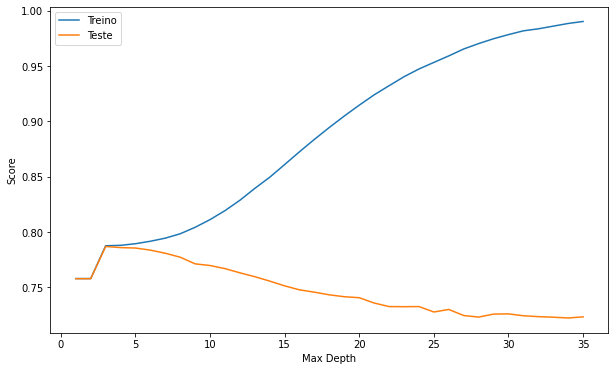

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.lineplot(x = 'max_depth', y = 'score_treino', data = df_resultados)
sns.lineplot(x = 'max_depth', y = 'score_teste', data = df_resultados)
plt.legend(["Treino","Teste"])
plt.xlabel('Max Depth')
plt.ylabel('Score')

Como pode ser visto, quando maior o score de treino, pior o score de teste, isso se dá por conta do overfitting do modelo para os dados de treino.

**Como podemos parametrizar nossos modelos de forma a otimizar os resultados?**

O método de rodar o modelo variando o hiperparâmetro é uma boa escolha, como no nosso exemplo, vimos que Max Depth = 3 é o valor ótimo da nossa Decision Tree.

Um modelo pode ter vários hiperparâmetros, outro presente na Decision Tree é o Min Samples Leaf, na qual especifica a quantidade minima de samples na folha da árvore. Como padrão esse valor é 1, porém uma árvore com 1 valor em cada folha é uma árvore completamente específica, ou seja, uma árvore com overfitting.

Podemos verificar a quantidade de samples nas folhas através na visualização da árvore de decisão:

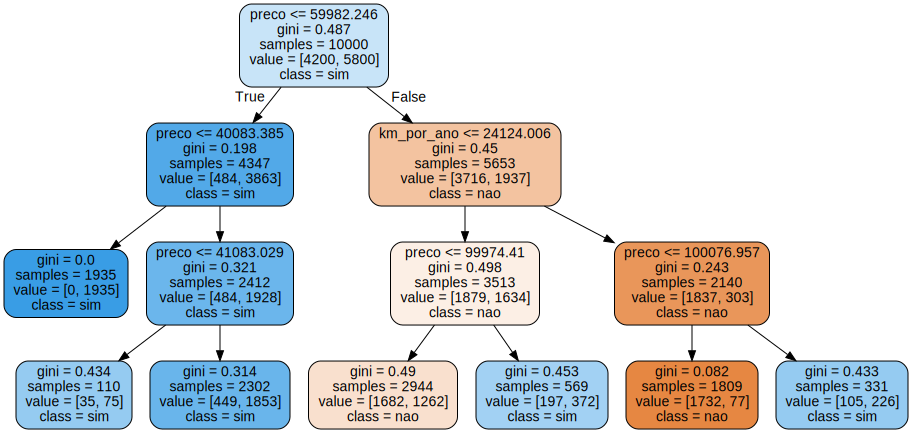

In [10]:
modelo = DecisionTreeClassifier(max_depth = 3)
grafico = desenha_arvore_decisao(modelo, x_azar, y_azar)
grafico

Como pode ser visto, a primeira folha possui 110 samples, a segunda 2302 e etc.

Para encontrar o conjunto ótimo de parâmetros (max_depth e min_samples_leaf), podemos rodar todas as possibilidades:

- Max_depth = 1 e min_samples_leaf = 1
- Max_depth = 1 e min_samples_leaf = 2
- ...
- Max_depth = 64 e min_samples_leaf = 63
- Max_depth = 64 e min_samples_leaf = 64

Dessa forma, encontramos a combinação com maior score:

In [11]:
resultados = []

for pmax_depth in range(1, 20):
    for pmin_samples_leaf in range(1, 20):
        resultado = roda_decision_tree(pmax_depth, pmin_samples_leaf)
        resultados.append(resultado)

df_maxDepth_minSamples = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'score_treino', 'score_teste', 'fit_time', 'score_time'])

In [12]:
df_maxDepth_minSamples.sort_values('score_teste', ascending = False).head()

,max_depth,min_samples_leaf,score_treino,score_teste,fit_time,score_time
46,3,9,0.787511,0.787,0.008349,0.000899
49,3,12,0.787511,0.787,0.008942,0.000931
41,3,4,0.787533,0.787,0.008344,0.000863
42,3,5,0.787511,0.787,0.008356,0.000882
43,3,6,0.787511,0.787,0.008314,0.000862


Rodando os testes, podemos ver que a combinação ótima ficou em Max Depth = 3 e Min Samples Leaf = 9.

Através da tabela de correlação, vemos que o hiperparâmetro Max Depth tem uma correlação negativa com o score_teste. Isso quer dizer que quanto maior o max_depth, menor o score teste. O inverso ocorre com o hiperparâmetro min_samples_leaf e score_teste:

In [13]:
correlacao = df_maxDepth_minSamples.corr()
correlacao

,max_depth,min_samples_leaf,score_treino,score_teste,fit_time,score_time
max_depth,1.000000,0.000000,0.907295,-0.673004,0.963781,0.660890
min_samples_leaf,0.000000,1.000000,-0.215611,0.146172,-0.106205,-0.063063
score_treino,0.907295,-0.215611,1.000000,-0.563822,0.934010,0.611402
score_teste,-0.673004,0.146172,-0.563822,1.000000,-0.612061,-0.628520
fit_time,0.963781,-0.106205,0.934010,-0.612061,1.000000,0.646873
score_time,0.660890,-0.063063,0.611402,-0.628520,0.646873,1.000000


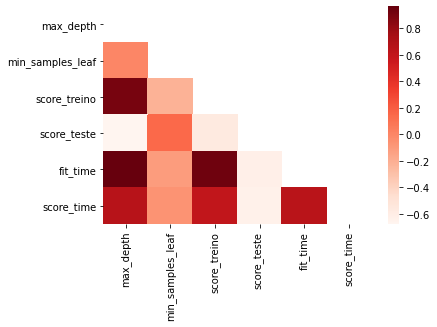

In [14]:
mask = np.triu(np.ones_like(correlacao, dtype=bool)) # Retira a parte de cima
sns.heatmap(correlacao, cmap = 'Reds', mask = mask)

# Grid Search CV

A DecisionTree possui muitos outros hiperparâmetros, porém aninhar fors torna o processo extremamente lento. Dessa forma, podemos utilizar a biblioteca GridSearchCV para trabalhar nesses cenários:

In [15]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

# definimos quais valores que queremos que sejam testados:
espaco_de_parametros = {
    'max_depth' : [3, 5],
    'min_samples_split' : [32, 64, 128],
    'min_samples_leaf' : [32, 64, 128],
    'criterion' : ['gini', 'entropy']
}

busca = GridSearchCV(
                        DecisionTreeClassifier(), 
                        espaco_de_parametros, 
                        cv = GroupKFold(n_splits = 10)
                    )
busca.fit(x_azar, y_azar, groups = x_azar.idade_do_modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008809,0.000710,0.001013,0.000300,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.829766,0.796813,0.821833,0.753012,0.768293,0.77988,0.76939,0.763795,0.775977,0.787083,0.025085,1
1,0.008873,0.000832,0.000926,0.000096,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.829766,0.796813,0.821833,0.753012,0.768293,0.77988,0.76939,0.763795,0.775977,0.787083,0.025085,1
2,0.009210,0.001345,0.001020,0.000261,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.829766,0.796813,0.821833,0.753012,0.768293,0.77988,0.76939,0.763795,0.775977,0.787083,0.025085,1
3,0.008707,0.000854,0.000945,0.000161,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.829766,0.796813,0.821833,0.753012,0.768293,0.77988,0.76939,0.763795,0.775977,0.787083,0.025085,1
4,0.008350,0.000123,0.000995,0.000163,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.829766,0.796813,0.821833,0.753012,0.768293,0.77988,0.76939,0.763795,0.775977,0.787083,0.025085,1


Podemos pedir o melhor conjunto de parâmetros encontrados dentro do nosso espaço de parâmetros:

In [16]:
print("Melhores parâmetros: ", busca.best_params_)
print("Melhor score: ", busca.best_score_)
print("Melhor estimador: ", busca.best_estimator_)

Melhores parâmetros:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
Melhor score:  0.787082568453911
Melhor estimador:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Podemos pegar o melhor estimador encontrado pelo GridSearchCV e testá-lo com os dados:

In [17]:
from sklearn.metrics import accuracy_score

melhor_modelo = busca.best_estimator_
predicoes = melhor_modelo.predict(x_azar)
acuracia = accuracy_score(predicoes, y_azar)

print("Acurácia: %.2f%%" % (acuracia * 100))

Acurácia: 78.75%


PORÉM, temos que evitar testá-lo dessa forma, pois estaremos sendo muito otimistas testando apenas uma vez com um conjunto de dados.

Queremos uma estimativa mais realista sem o vício nos dados já vistos. Então fazemos uma nova validação cruzada, que se chama **Nested Cross Validation**:

In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = x_azar.idade_do_modelo)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The 'groups' parameter should not be None.

  FitFailedWarning)


O Nested Cross Validation possui um BUG com o GroupKFold, causando o erro:
    
    The 'groups' parameter should not be None.

Enquanto o bug não é corrigido, podemos utilizar o KFold normal.

In [19]:
busca = GridSearchCV(
                        DecisionTreeClassifier(), 
                        espaco_de_parametros, 
                        cv = KFold(n_splits = 10, shuffle=True)
                    )
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008906,0.001000,0.001152,0.000714,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.787,0.772,0.779,0.778,0.809,0.803,0.8,0.781,0.771,0.789,0.7869,0.01255,1
1,0.009125,0.000925,0.000968,0.000121,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.787,0.772,0.779,0.778,0.809,0.803,0.8,0.781,0.771,0.789,0.7869,0.01255,1
2,0.008615,0.000565,0.000876,0.000046,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.787,0.772,0.779,0.778,0.809,0.803,0.8,0.781,0.771,0.789,0.7869,0.01255,1
3,0.008653,0.000604,0.000922,0.000119,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.787,0.772,0.779,0.778,0.809,0.803,0.8,0.781,0.771,0.789,0.7869,0.01255,1
4,0.008483,0.000150,0.000869,0.000028,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.787,0.772,0.779,0.778,0.809,0.803,0.8,0.781,0.771,0.789,0.7869,0.01255,1


In [20]:
print("Melhores parâmetros: ", busca.best_params_)
print("Melhor score: ", busca.best_score_)
print("Melhor estimador: ", busca.best_estimator_)

Melhores parâmetros:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
Melhor score:  0.7868999999999999
Melhor estimador:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Agora sim podemos rodar o Cross Val Score

In [23]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=10, shuffle=True))
scores

array([0.776, 0.81 , 0.773, 0.772, 0.783, 0.792, 0.783, 0.792, 0.78 ,
       0.806])

# Resultados de acurácia com os melhores parâmetros da Decision Tree:

In [25]:
intervalo_acuracia = [scores.mean()-(2*scores.std()), scores.mean()+(2*scores.std())]

print("Resultados parciais: ", scores)
print("Média de acurácia: %.2f%%" % (scores.mean() * 100))
print("Intervalo de acurácia: %.2f%% ~ %.2f%%" % (intervalo_acuracia[0]*100, intervalo_acuracia[1]*100))

Resultados parciais:  [0.776 0.81  0.773 0.772 0.783 0.792 0.783 0.792 0.78  0.806]
Média de acurácia: 78.67%
Intervalo de acurácia: 76.17% ~ 81.17%
